In [68]:
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


In [19]:
# Check DB file is accessible and connect to db

db_path = "../database/thermostat_analysis.db"

if os.path.exists(db_path):
    conn = sqlite3.connect(db_path)
    print("Connected to DB successfully.")
else:
    print("DB file not found. Please check the path.")

Connected to DB successfully.


In [20]:
# To ensure if the connection is successful

cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables:", tables)

Tables: [('weather_data',), ('weather_data_final',), ('thermostat_data_final',), ('thermostat_data_hourly',)]


 ### **Resampling & Merging with Weather Data**

The original thermostat dataset was logged at **5-minute intervals**. To align it with the hourly weather data,  performed a **custom resampling to 1-hour intervals**, aggregating relevant fields:

- Temperature and humidity fields: **mean**
- Fan runtime (`fan_sec`): **sum**
- Categorical fields (e.g., `system_mode`, `program_mode`): **mode**

After resampling, saved the data as `thermostat_df_hourly_custom.csv`.

Then performed an **inner SQL join** with the cleaned weather dataset (`weather_data_final`) using the common `timestamp` field.

Result:
- A clean, merged hourly dataset with both indoor HVAC performance and outdoor weather conditions parameters.
- Ready for time series analysis and visualization.

In [63]:
# Define SQL JOIN query

query = """
SELECT 
    t.timestamp,
    t.system_mode,
    t.program_mode,
    t.cool_set_temp_f,
    t.heat_set_temp_f,
    t.current_temp_f,
    t.current_humidity_rh,            
    t.fan_sec,
    t.fan_runtime_category,
    w.outdoor_temp_f,
    w.outdoor_humidity
FROM 
    thermostat_data_hourly t
JOIN 
    weather_data_final w
ON 
    t.timestamp = w.timestamp
ORDER BY 
    t.timestamp;
"""

In [ ]:
# Execute the query

merged_df = pd.read_sql_query(query, conn)

In [ ]:
# Close the connection

conn.close()

In [ ]:
# Preview the merged data

merged_df.head(5)

,timestamp,system_mode,program_mode,cool_set_temp_f,heat_set_temp_f,current_temp_f,current_humidity_rh,fan_sec,fan_runtime_category,outdoor_temp_f,outdoor_humidity
0,2024-05-01 00:00:00,compressorcooloff,sleep,74.5,69.5,72.88,57.0,3300.0,High,58.46,75
1,2024-05-01 01:00:00,compressorcooloff,sleep,74.5,69.5,72.43,57.0,3300.0,High,56.30,80
2,2024-05-01 02:00:00,compressorcooloff,sleep,74.5,69.5,72.05,57.0,3300.0,High,55.04,83
3,2024-05-01 03:00:00,compressorcooloff,sleep,74.5,69.5,71.59,57.0,3300.0,High,54.14,86
4,2024-05-01 04:00:00,compressorcooloff,sleep,74.5,69.5,71.17,57.0,3300.0,High,54.14,88


In [ ]:
# Save the merged df to a CSV file

merged_df.to_csv("../data/processed/merged_thermostat_weather_data.csv", index=False)

print("Merged data saved to: ../data/processed/merged_thermostat_weather_data.csv")

Merged data saved to: ../data/processed/merged_thermostat_weather_data.csv


In [ ]:
# Ensure timestamp is already datetime

merged_df['timestamp'].dtype

dtype('O')

In [ ]:
# since the dtype is String, converting it into datetime format suitable for line plots and time-based filters

merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

In [ ]:
merged_df.set_index('timestamp', inplace=True)

### Timestamp Consistency Check (1-Hour Interval)

To ensure the `merged_df` dataset is properly structured for time series analysis, I checked the time difference between consecutive timestamps using the following code:

```python
merged_df.index.to_series().diff().value_counts().head(10)
O/P:
0 days 01:00:00    10223 
```

### Interpretation:
- All timestamps are spaced exactly 1 hour apart, confirming a regular hourly interval.
- This ensures the time series is clean, evenly spaced, and ready for analysis such as daily/weekly trends, system behavior over time, and correlation with weather data.

In [29]:
#Confirm that all intervals are 1 hour
merged_df.index.to_series().diff().value_counts().head(10)

timestamp
0 days 01:00:00    10223
Name: count, dtype: int64

### Timestamp Component Extraction
- Extracted key components from the `timestamp` column in the merged dataset, to enable time_based grouping and anlysis
- Makes it easier to analyzze trends like daily usage, hourly patterns, or weekday/weekend behaviors.

In [31]:
print(merged_df.index.name)

timestamp


In [33]:
merged_df.index.dtype

dtype('<M8[ns]')

In [34]:
# Extract timestamp components

merged_df['date'] = merged_df.index.date
merged_df['hour'] = merged_df.index.hour
merged_df['month'] = merged_df.index.month
merged_df['weekday'] = merged_df.index.day_name()

In [36]:
merged_df.columns


Index(['system_mode', 'program_mode', 'cool_set_temp_f', 'heat_set_temp_f',
       'current_temp_f', 'current_humidity_rh', 'fan_sec',
       'fan_runtime_category', 'outdoor_temp_f', 'outdoor_humidity', 'date',
       'hour', 'month', 'weekday'],
      dtype='object')

# Visualization

## 1. HVAC Runtime Over Time

### Objective

To understand how long the HVAC fan operates across different time periods (daily, hourly, and by duration category). This helps reveal usage patterns, inefficiencies, or potential overuse.

### Outcomes
- Identifying daily peaks or anomalies in HVAC usage
- Detecting high-load hours where HVAC runs the most
- Understanding how often the fan runs for short, medium, or long durations
This lays the foundation for energy optimization by aligning usage with comfort needs and potential savings.

### 1A.  Daily Total Fan Runtime (Line Chart)

- Purpose: Visualize how much time the HVAC fan runs each day.
- Insight: Detect abnormal usage days that may indicate inefficient system settings or unusual behavior.

**Chart Insight**:  
- This line chart displays the **daily total HVAC fan runtime** (in hours) over the course of a year.  
- The consistent runtime between 23–24 hours during some periods reflects **manual fan settings** (55 min/hour).  
- The visible dips and occasional spikes are useful for identifying anomalies, power interruptions, or HVAC behavior changes due to external temperature or system modes.

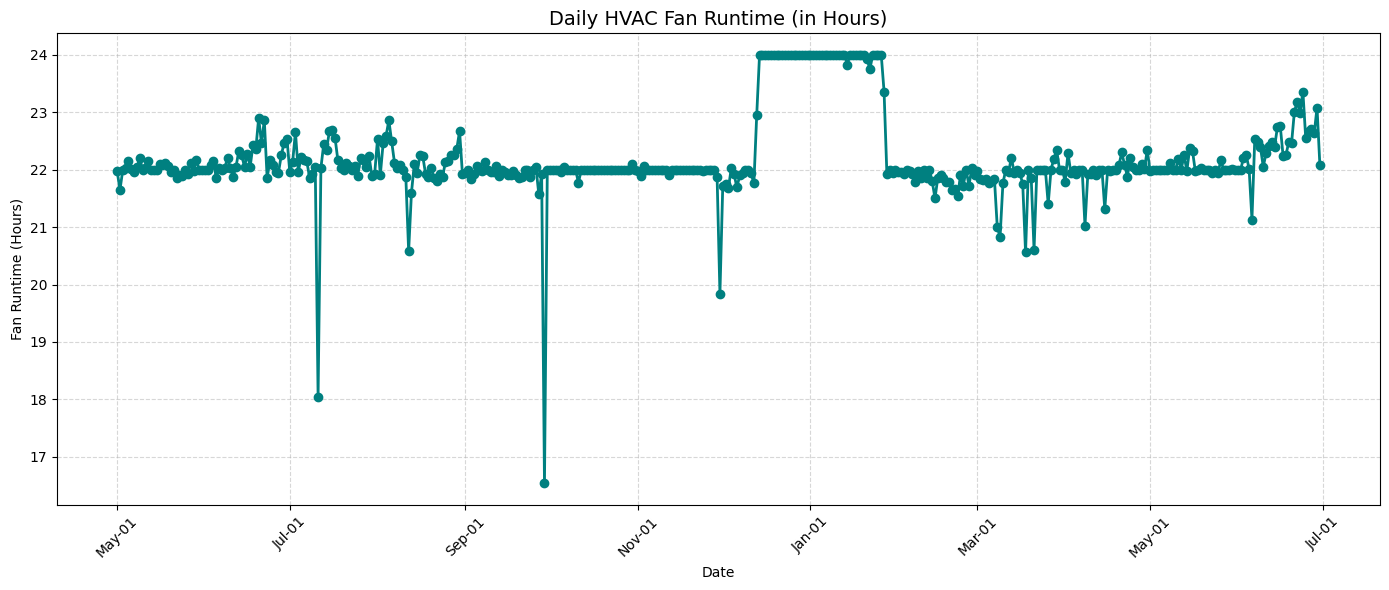

In [109]:
### 1A.  Daily Total Fan Runtime (Line Chart)

# Grouping data by date and summing total fan runtime in seconds per day
daily_runtime = merged_df.groupby('date')['fan_sec'].sum().reset_index()

# Converting fan runtime from seconds to hours and rounding to 2 decimal places
daily_runtime['fan_runtime_hours'] = (daily_runtime['fan_sec'] / 3600).round(2)

# Setting the chart size
plt.figure(figsize=(14, 6))

# Plotting the line chart with markers and custom color
plt.plot(daily_runtime['date'],                # x-axis: Date
         daily_runtime['fan_runtime_hours'],   # y-axis: Total runtime in hours
         marker='o', linestyle='-', color='teal', linewidth=2)

# Adding chart title and axis labels
plt.title('Daily HVAC Fan Runtime (in Hours)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Fan Runtime (Hours)')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Formatting x-axis date labels (e.g., Apr-01, May-02)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

# Adding grid lines with dashed style and transparency
plt.grid(True, linestyle='--', alpha=0.5)

# Adjusting layout to prevent clipping
plt.tight_layout()

# Save and display the final plot
plt.savefig('../outputs/charts/daily_hvac_fan_runtime.png', dpi=300)
plt.show()
plt.close()

### 1B. Fan Runtime by Hour of Day (Bar Chart)

- Purpose: Understand which time of the day the HVAC is used most.
- Insight: Identify peak load hours for better scheduling or thermostat programming.

**ChartInsights**:
- This chart displays the total fan runtime (in hours) for each hour of the day (0–23), aggregated across 14 months of data.
- Given that the thermostat is configured to run the fan 55 minutes every hour, the bars hover around 390 hours (55 mins × ~570 days / 60), which is expected.
- The nearly uniform height across all 24 hours reflects consistent hourly usage, confirming the accuracy of both the dataset and the thermostat configuration.

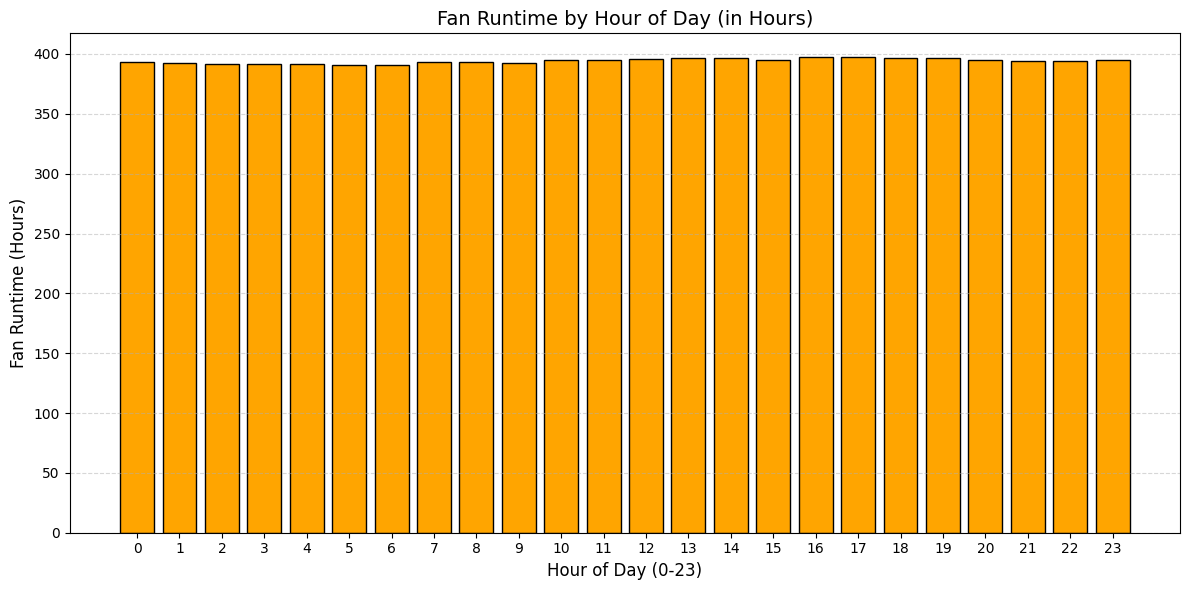

In [110]:
# 1B. Fan Runtime by Hour of Day (Bar Chart)

# Group the data by hour of the day and sum the fan runtime in seconds
hourly_runtime = merged_df.groupby('hour')['fan_sec'].sum().reset_index()

# Convert fan runtime from seconds to hours and round to 2 decimal places
hourly_runtime['fan_runtime_hours'] = (hourly_runtime['fan_sec'] / 3600).round(2)

# Create a bar chart to visualize fan usage by hour
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot a bar chart with hour on X-axis and runtime in hours on Y-axis
plt.bar(hourly_runtime['hour'], hourly_runtime['fan_runtime_hours'],
        color='orange', edgecolor='black')  # Set color and edge style

# Set the title and axis labels
plt.title('Fan Runtime by Hour of Day (in Hours)', fontsize=14)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Fan Runtime (Hours)', fontsize=12)
plt.xticks(range(0, 24))  # Show each hour clearly

# Show a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Make layout tight so labels and titles fit well
plt.tight_layout()

# Save and Display the plot
plt.savefig('../outputs/charts/fan_runtime_by_hour_of_day.png', dpi=300)
plt.show()
plt.close()

### 1C — Seasonal HVAC Runtime (Totals)
- To understand how HVAC fan usage changes across the four seasons, providing insight into seasonal energy demand patterns.
- This helps identify whether extreme temperatures (in summer/winter) significantly increase runtime and informs possible strategies for improving efficiency during high-demand periods.

#### Data Preparation Steps
1. Daily Aggregation
Resampled the data to daily totals, converting fan_sec (seconds) into hours.

2. Season Mapping
Assigned each month to a season (Winter, Spring, Summer, Fall) based on the Northern Hemisphere.

3. Season Ordering
Ensured a consistent order (Winter → Spring → Summer → Fall) for clear visualization.

4. Color Mapping
Applied distinct colors for each season to improve chart readability.



In [ ]:
# Prep: daily runtime & season labeling

# Resample to daily totals (sum of seconds per day), keeping both seconds and hours
daily_rt = merged_df['fan_sec'].resample('D').sum().to_frame('fan_sec')
daily_rt['hours'] = (daily_rt['fan_sec'] / 3600).round(2)

# Map month → season 
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
daily_rt['season'] = daily_rt.index.month.map(season_map)  # add season label column

# Order seasons for consistent plotting
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Defining a simple seasonal color palette 
season_colors = {
    'Winter': '#4C78A8',  # cool blue
    'Spring': '#59A14F',  # fresh green
    'Summer': '#F28E2B',  # warm orange
    'Fall':   '#E15759',  # autumn red
}

#### Seasonal Total Runtime (Bar Chart)
- Shows the total HVAC fan runtime (in hours) aggregated for each season.

**ChartInsights:**

- Peaks in Summer and Spring indicate higher HVAC usage due to cooling and heating demands.
- Winter and Fall show significantly lower totals.
- Higher spring usage likely reflects both heating and cooling needs within the same day.

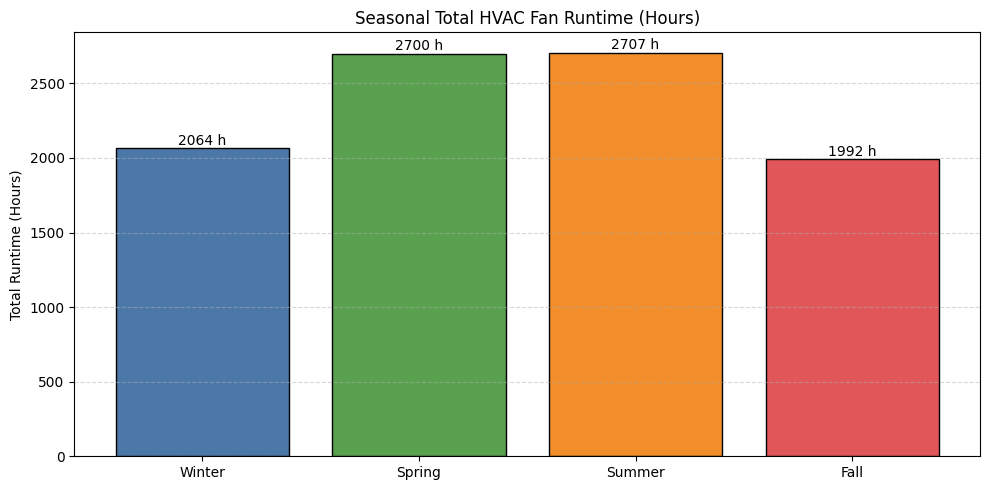

In [112]:
# Seasonal Total Runtime (bar)

# Sum daily hours within each season and order by season_order

season_totals = (
    daily_rt.groupby('season')['hours']
    .sum()
    .reindex(season_order)
)

# Create bar chart of total runtime per season

plt.figure(figsize=(10, 5))  # set figure size
bars = plt.bar(
    season_totals.index,                 # x categories: seasons
    season_totals.values,                # y values: total hours
    color=[season_colors[s] for s in season_totals.index],  # map color by season
    edgecolor='black'                    # outline for readability
)

# Add value labels above each bar

for b in bars:
    y = b.get_height()
    plt.text(
        b.get_x() + b.get_width()/2,    # center of bar
        y + 1,                          # a bit above the bar
        f'{y:.0f} h',                   # whole hours label
        ha='center', va='bottom', fontsize=10
    )

# Plot show

plt.title('Seasonal Total HVAC Fan Runtime (Hours)')
plt.ylabel('Total Runtime (Hours)')
plt.grid(axis='y', linestyle='--', alpha=0.5)  # horizontal gridlines
plt.tight_layout()
# Save and display plots
plt.savefig('../outputs/charts/seasonal_total_hvac_hourly_fan_runtime .png', dpi=300)
plt.show()
plt.close()

## 2. Setpoint vs. Actual Indoor Temperature Analysis
This section compares the thermostat setpoint with the actual indoor temperature to evaluate HVAC performance.  
**Goals:**
- Assess how closely the HVAC system maintains the target temperature.
- Identify patterns of overcooling or overheating across seasons.
- Provide a quick seasonal average deviation table for numeric context.

**GraphInsights:**  
- If the actual temperature line closely follows the setpoint line, the system is performing well.  
- Deviations indicate possible HVAC lag, overshoot, or seasonal load differences.

- Winter: Average indoor temperature was 1.75°F colder than the setpoint — could suggest slight overcooling or HVAC overshoot in heating mode.
- Spring: 0.51°F colder than setpoint — fairly close tracking.
- Summer: 0.64°F warmer than setpoint — small lag in cooling, possibly due to higher outdoor load.
- Fall: 0.61°F colder than setpoint — minor overshoot in cooling or transitional weather effects.

**Interpretation:**
Across all seasons, the system generally stays within ±2°F of the target, which is acceptable for comfort, with winter showing the largest average deviation.

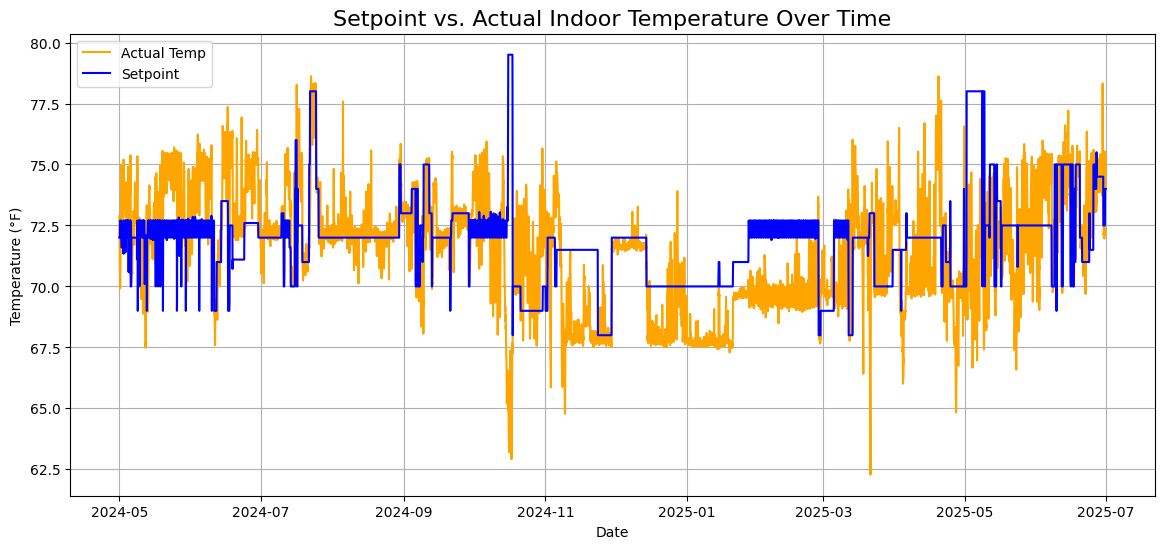

Average Temp Difference by Season (°F):
   season  temp_diff
0  Winter      -1.75
1  Spring      -0.51
2  Summer       0.64
3    Fall      -0.61


In [113]:
# Setpoint vs. Actual Indoor Temperature Analysis
# Copy the merged dataset to avoid modifying the original

df = merged_df.copy()

# Create a single target setpoint as the average of heating and cooling setpoints
# This avoids having to determine system mode for each reading
df['target_setpoint'] = df[['cool_set_temp_f', 'heat_set_temp_f']].mean(axis=1).round(2)

# Calculate difference between actual indoor temp and setpoint
df['temp_diff'] = df['current_temp_f'] - df['target_setpoint']

# Round to 2 decimal places for cleaner display
df['temp_diff'] = df['temp_diff'].round(2)

# Smooth actual temp (1 hour = 12 readings if 5-min intervals)
# df['actual_temp_smooth'] = df['current_temp_f'].rolling(window=12, center=True).mean()


# Map month to seasons
def month_to_season(m):
    if m in [12, 1, 2]: return 'Winter'
    if m in [3, 4, 5]:  return 'Spring'
    if m in [6, 7, 8]:  return 'Summer'
    if m in [9, 10, 11]:return 'Fall'

df['season'] = df['month'].apply(month_to_season)
df['season'] = pd.Categorical(df['season'],
                               categories=['Winter','Spring','Summer','Fall'],
                               ordered=True)

# Seasonal average deviation (°F), rounded to 2 decimal places
seasonal_avg_diff = (
    df.groupby('season', observed=False)['temp_diff']
      .mean()
      .round(2)
      .reset_index()
)

# Plot: Setpoint vs Actual Temperature over time
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='timestamp', y='current_temp_f', label='Actual Temp', color='orange')
sns.lineplot(data=df, x='timestamp', y='target_setpoint', label='Setpoint', color='blue')
plt.title('Setpoint vs. Actual Indoor Temperature Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
# Save and display plots
plt.savefig('../outputs/charts/setpoint_vs_acutal_indoor_temp.png', dpi=300)
plt.show()
plt.close()

# Display the seasonal deviation table
print("Average Temp Difference by Season (°F):")
print(seasonal_avg_diff)

## 3. Indoor vs Outdoor Temperature — Daily Average Trend

Compare daily average indoor and outdoor temperatures to see how well the HVAC maintains indoor comfort as weather changes.

### 1. Indoor vs Outdoor Temperature Over Time (Line Chart)
- Shows daily average indoor vs outdoor temperatures.
- Helps visualize how the system reacts to extreme outdoor temps.

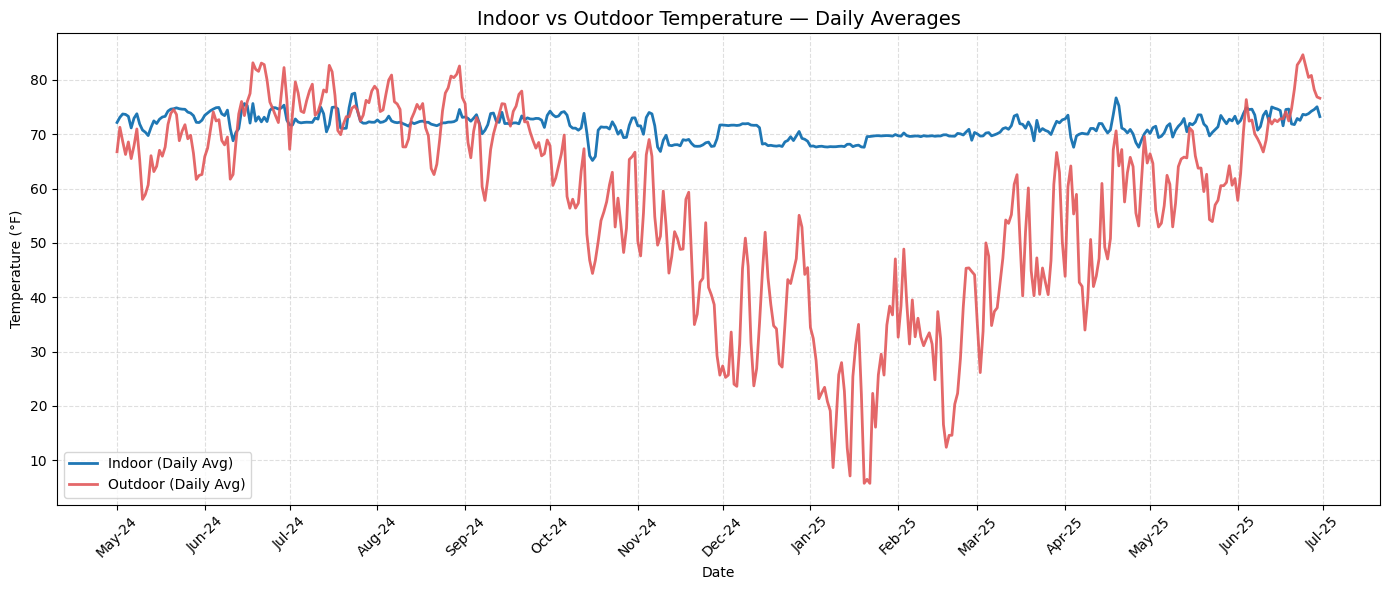

In [114]:
# Indoor vs Outdoor Temperature Over Time
# Copy the merged dataset to avoid modifying the original
temp_df = merged_df.copy()

# If not already a DatetimeIndex, convert and set 
if 'timestamp' in temp_df.columns:
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], errors='coerce')
    temp_df = temp_df.dropna(subset=['timestamp']).set_index('timestamp')
else:
    # If timestamp is already the index, ensure it’s datetime dtype
    temp_df.index = pd.to_datetime(temp_df.index, errors='coerce')



# Keep only the columns we need for this chart (indoor/outdoor temps)
cols_needed = ['current_temp_f', 'outdoor_temp_f']
df_temps = temp_df[cols_needed].copy()



# Drop rows where BOTH temps are missing (keeps rows if at least one exists)
df_temps = df_temps.dropna(how='all', subset=cols_needed)

# Daily aggregation

# Resample to daily averages (smooths hourly noise to daily means)
daily_temp = df_temps.resample('D').mean()


# Plot: Indoor vs Outdoor (Daily Avg)

plt.figure(figsize=(14, 6))  # Wider chart for long timelines

# Plot indoor daily average
plt.plot(
    daily_temp.index, daily_temp['current_temp_f'],
    label='Indoor (Daily Avg)',
    color='#1f77b4', linewidth=2
)

# Plot outdoor daily average
plt.plot(
    daily_temp.index, daily_temp['outdoor_temp_f'],
    label='Outdoor (Daily Avg)',
    color='#e15759', linewidth=2, alpha=0.9
)


# Titles and labels
plt.title('Indoor vs Outdoor Temperature — Daily Averages', fontsize=14)
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')

# Nice date formatting on x‑axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # e.g., Jan-25
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tick monthly
plt.xticks(rotation=45)

# Grid, legend, layout
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()

# Save and display plots
plt.savefig('../outputs/charts/indoor_vs_outdoor_temp.png', dpi=300)
plt.show()
plt.close()
